In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

import os, sys, importlib, gc
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
mask_folder = '../masks/'
fit_out_folder = './data/fit_outs/'
Idt_folder = './data/Idts/'
g2_folder = './data/g2/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1350, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load masks

In [2]:
e4m_htmask = np.load(mask_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(mask_folder+'e4m_mask'+'.npy')

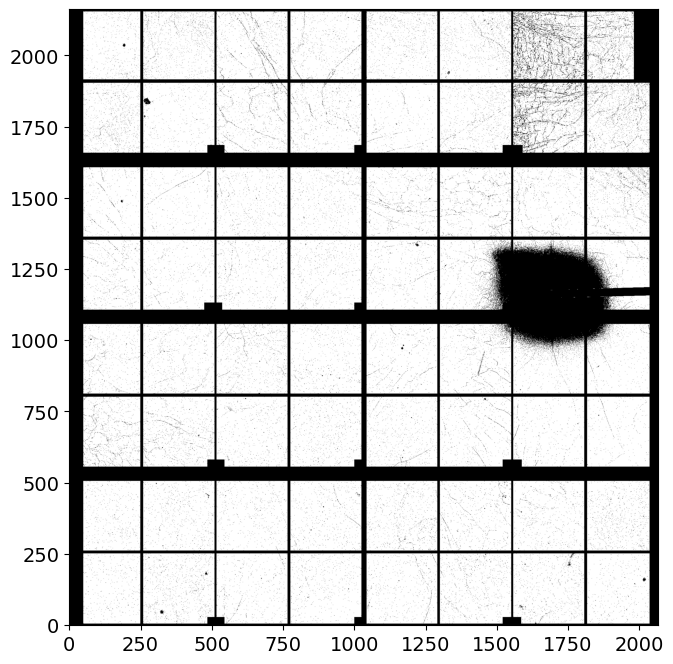

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

### BS mask and Q definition
Using a random scan in GeO2_6, because we are not changing the measurement configuration

#### Beamstop mask

In [4]:
#######################################
sample_name = 'GeO2_7_30C'
Ndataset = 3
Nscan = 3
Nfi, Nff = 0, 10000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/3 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/3 loops)
Done! (elapsed time = 0.11 s)
Concatenating vectors ...
Done! (elapsed time = 0.04 s)
	 | Sparse array loaded from ../RAW_DATA/GeO2_7_30C/GeO2_7_30C_0003/scan0003/
	 | Shape:       (10000, 4471016)
	 | Sparsity:     1.6e-04
	 | Memory usage (scipy.csr_array): 0.080 GB (np.array usage: 166.558 GB)


################################################################################
Maximum count in the hull run -> 253.0
# of pixels above Ith_high treshold ->  78 pixels (of 4471016 => 0.0 %)
################################################################################



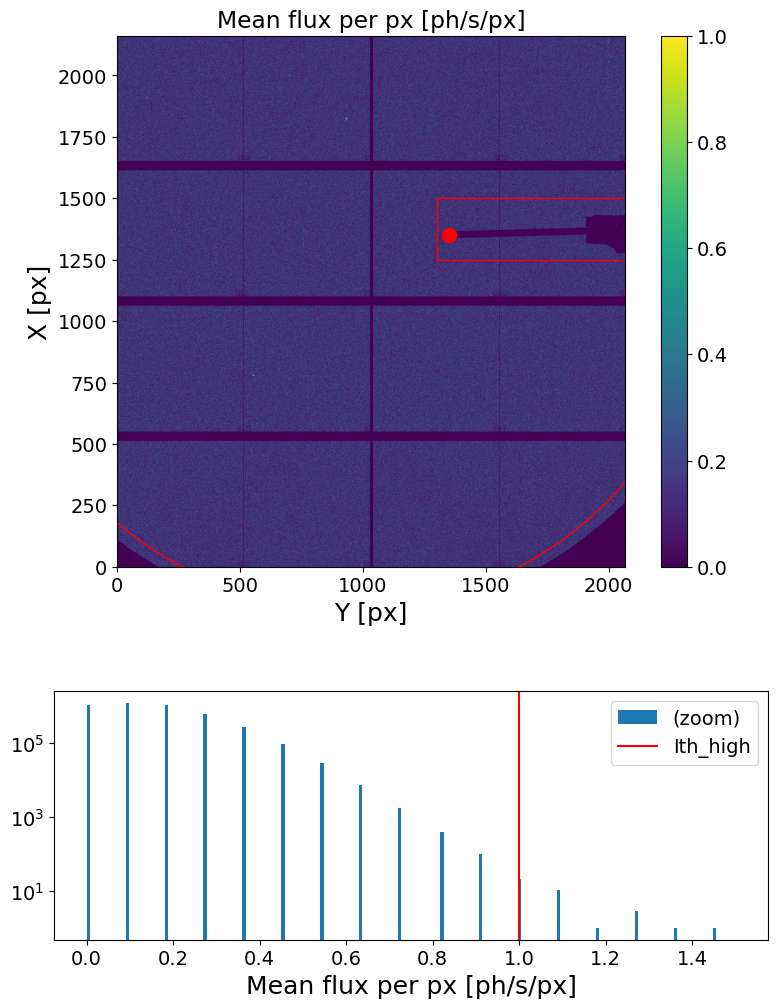

In [5]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1300, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, mask_geom=geom,)

#################################################
Masked area =  93.74594052000708 %
#################################################



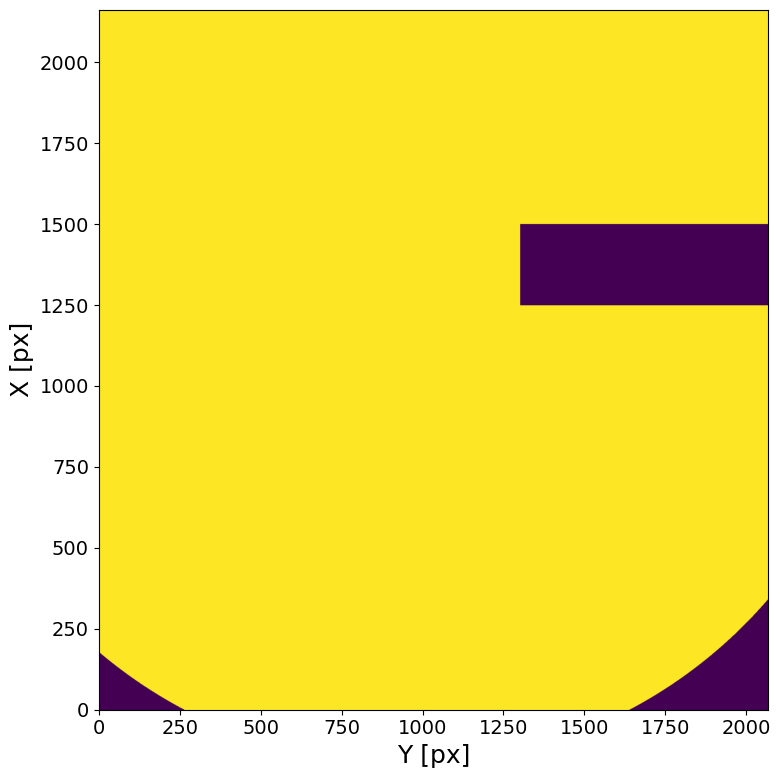

In [6]:
bs_mask = XPCS.gen_mask(e4m_data, itime, mask=None, mask_geom=geom)

#### Q mask

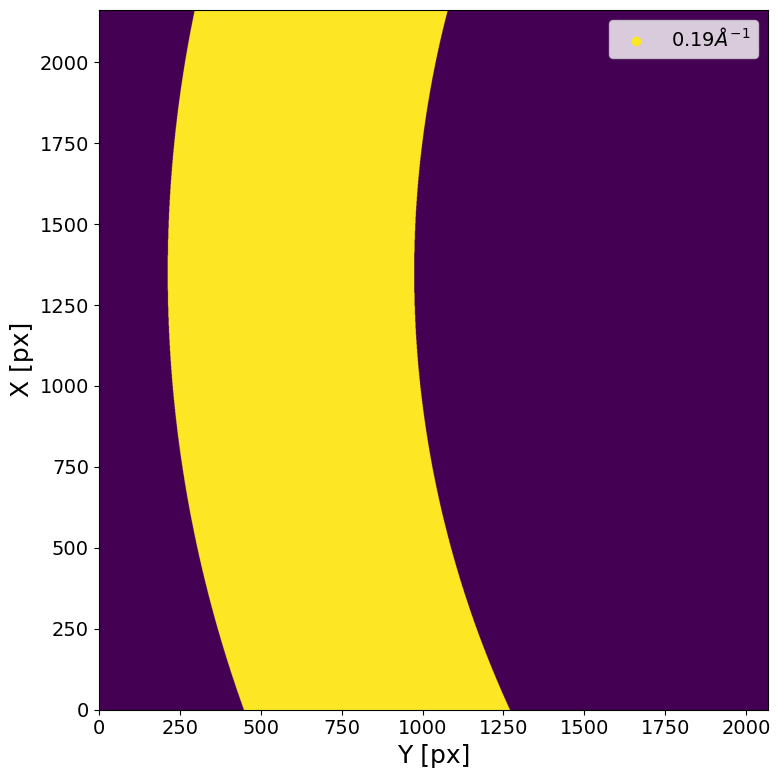

In [7]:
Qmask = XPCS.gen_Qmask(Ei, theta, .19, .02, Qmap_plot=False)

## XPCS scan (T = 30C Q =  0.19 Å, 30 min @ 1ms (1_800_000fm)) (GeO2_7, dataset 3, scan 3) fresh point

In [8]:
#######################################
sample_name = 'GeO2_7_30C'
Ndataset = 3
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask*e4m_htmask*bs_mask*Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff, load_mask=load_mask, n_jobs=60, )
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00017.h5 (18/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00014.h5 (15/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3049983 pixels (of 4471016 => 68.22 %)
################################################################################



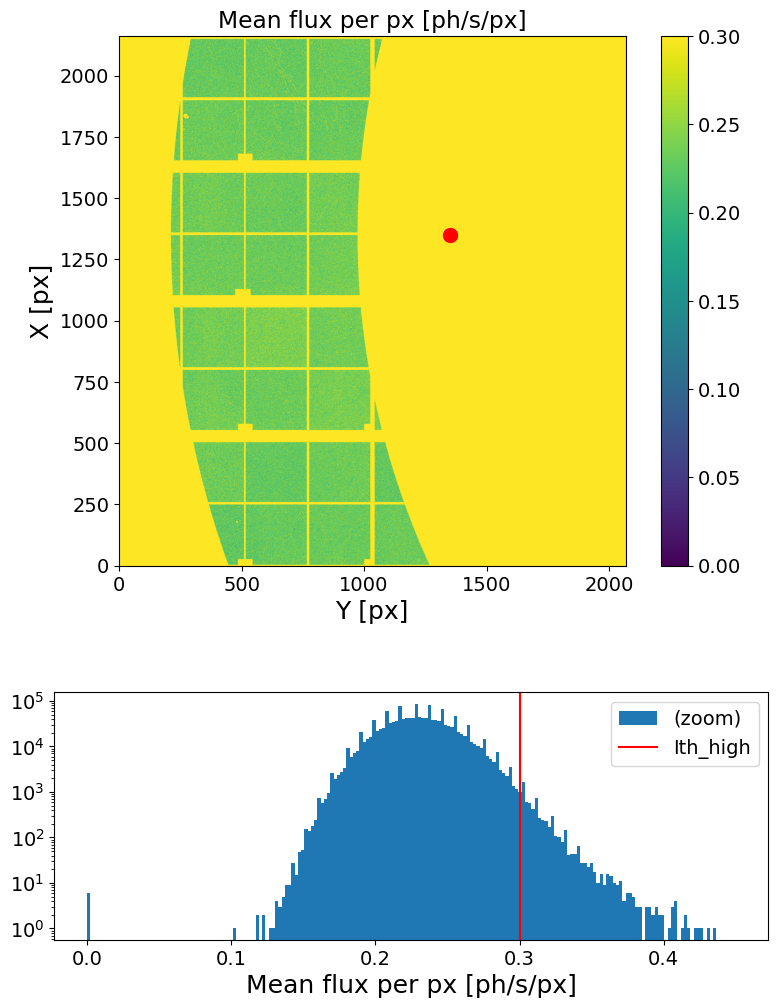

In [9]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [10]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

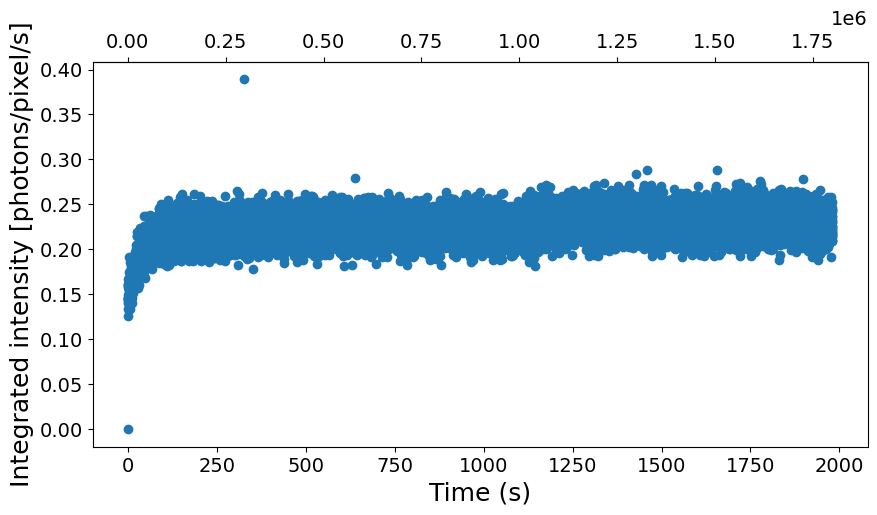

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [12]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 1800288    =>    log2(Nf) = 20.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**20                 20             41.8         751712
1    3*2**19                 19             13.0         227424
2   13*2**17                 17              5.0          96352
3   27*2**16                 16              2.0          30816
4  109*2**14                 14              1.0          14432
5  219*2**13                 13              0.0           6240
6  439*2**12                 12              0.0           2144
7  879*2**11                 11              0.0             96
----------------------------------------------------


In [14]:
##### INPUTS #####
Nfi = 60000
Nff = 60000 + 3*2**19
sparse_depth = 12
dense_depth = 19
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 7.26 s)
	 | 1572864 frames X 1427140 pixels
	 | sparsity = 2.48e-04
	 | memory usage (sparse.csr_array @ float32) = 6.24 GB
Computing sparse multitau G2t...


100%|██████████| 384/384 [02:25<00:00,  2.64it/s]


Done! (elapsed time = 146.93 s)
Computing dense multitau G2t...


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

Done! (elapsed time = 3.33 s)


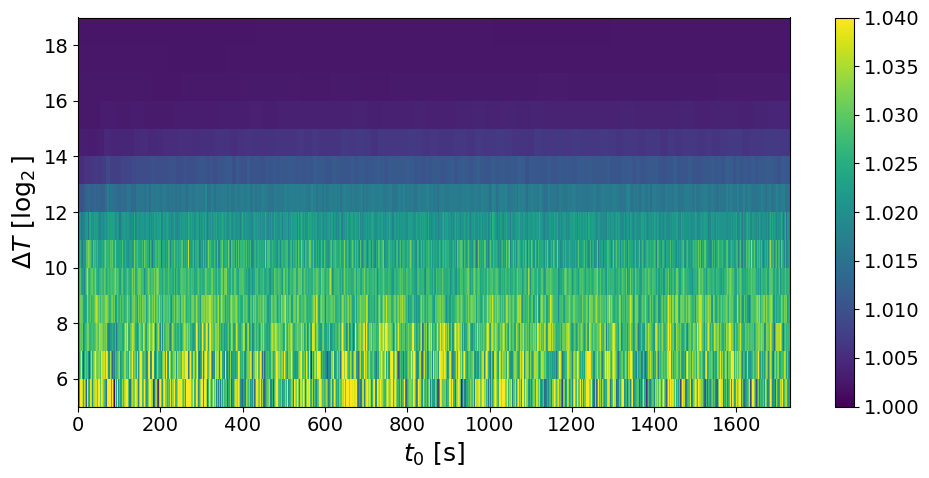

In [15]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [16]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

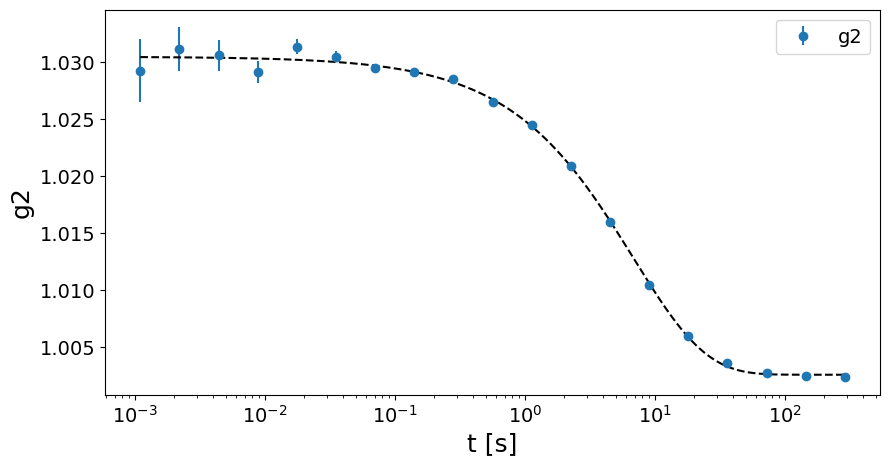

####### Fit parameters #######
tau = 6.8039 +/- 0.3758 s
beta = 0.7782 +/- 0.0388
c = 0.0279 +/- 0.0004
y0 = 1.0026 +/- 0.0003


In [18]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 100C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [19]:
#######################################
sample_name = 'GeO2_7_100C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file	 -> loading file  eiger4m_v2_sparse_frame_0_00025.h5eiger4m_v2_sparse_frame_0_00023.h5  (26/361 loops)(24/361 loops)

	 -> loading file eiger4m_v2_sparse_frame_0_00032.h5 (33/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00038.h5 (39/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00030.h5 (31/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00012.h5 (13/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00040.h5 (41/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file	 -> loading file  eiger4m_v2_sparse_frame_0_00000.h5eiger4m_v2_sparse_frame_0_00001.h5  (1/361 loops)(2/361 loops)

	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3045554 pixels (of 4471016 => 68.12 %)
################################################################################



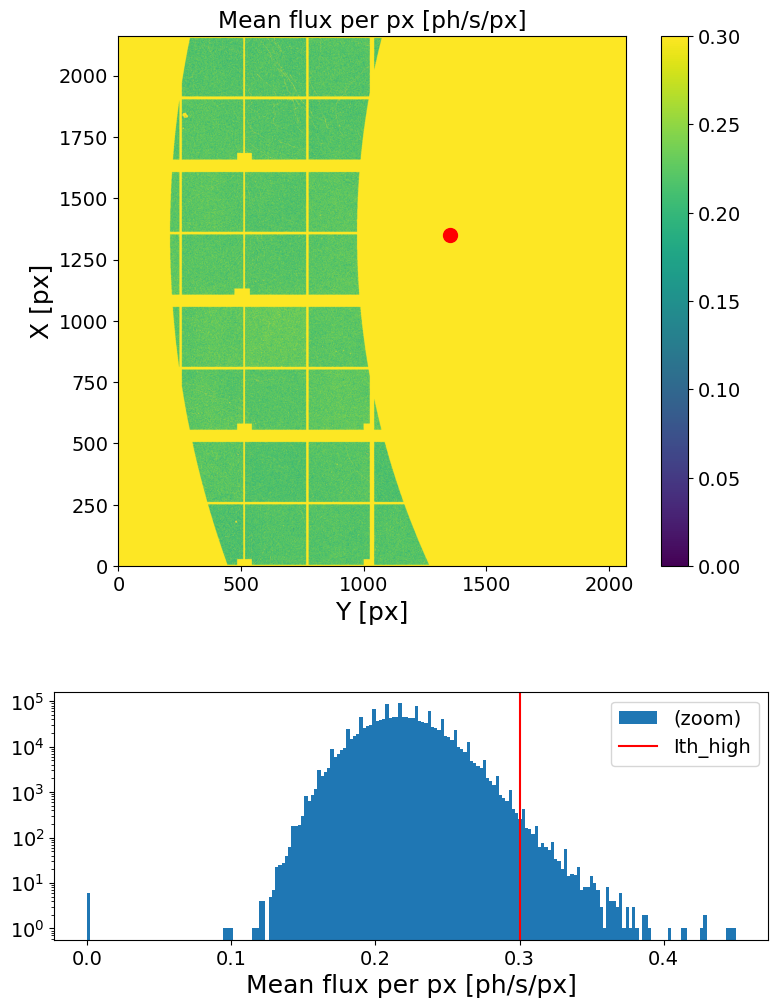

In [20]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [21]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

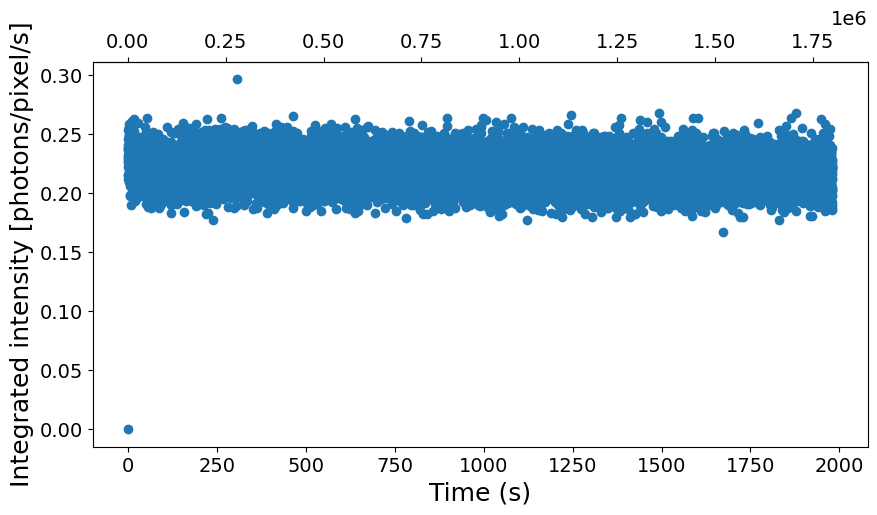

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [23]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 1800288    =>    log2(Nf) = 20.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**20                 20             41.8         751712
1    3*2**19                 19             13.0         227424
2   13*2**17                 17              5.0          96352
3   27*2**16                 16              2.0          30816
4  109*2**14                 14              1.0          14432
5  219*2**13                 13              0.0           6240
6  439*2**12                 12              0.0           2144
7  879*2**11                 11              0.0             96
----------------------------------------------------


In [26]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**19
sparse_depth = 11
dense_depth = 19
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 6.39 s)
	 | 1572864 frames X 1427140 pixels
	 | sparsity = 2.42e-04
	 | memory usage (sparse.csr_array @ float32) = 6.082 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [02:23<00:00,  5.36it/s]


Done! (elapsed time = 143.25 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

Done! (elapsed time = 6.08 s)


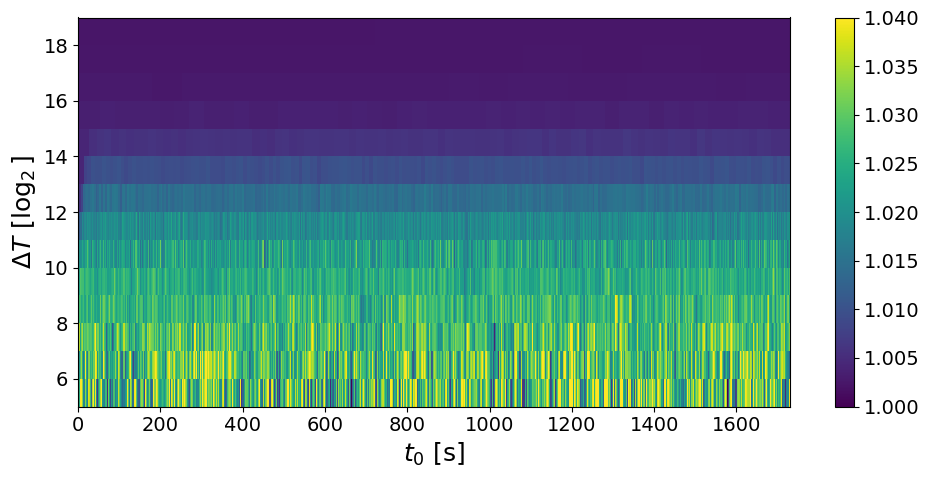

In [27]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [28]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

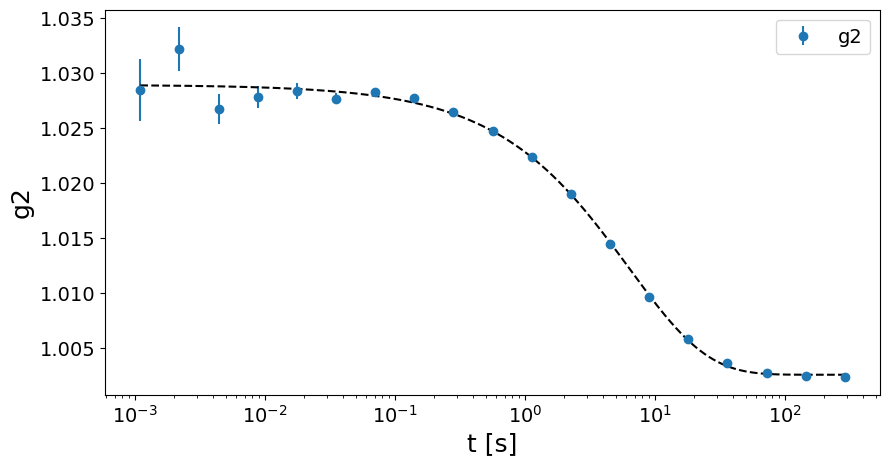

####### Fit parameters #######
tau = 6.3186 +/- 0.7074 s
beta = 0.7235 +/- 0.0688
c = 0.0264 +/- 0.0008
y0 = 1.0026 +/- 0.0006


In [29]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 170C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [9]:
#######################################
sample_name = 'GeO2_7_170C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...


	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00028.h5 (29/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00020.h5 (21/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00019.h5 (20

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3044289 pixels (of 4471016 => 68.09 %)
################################################################################



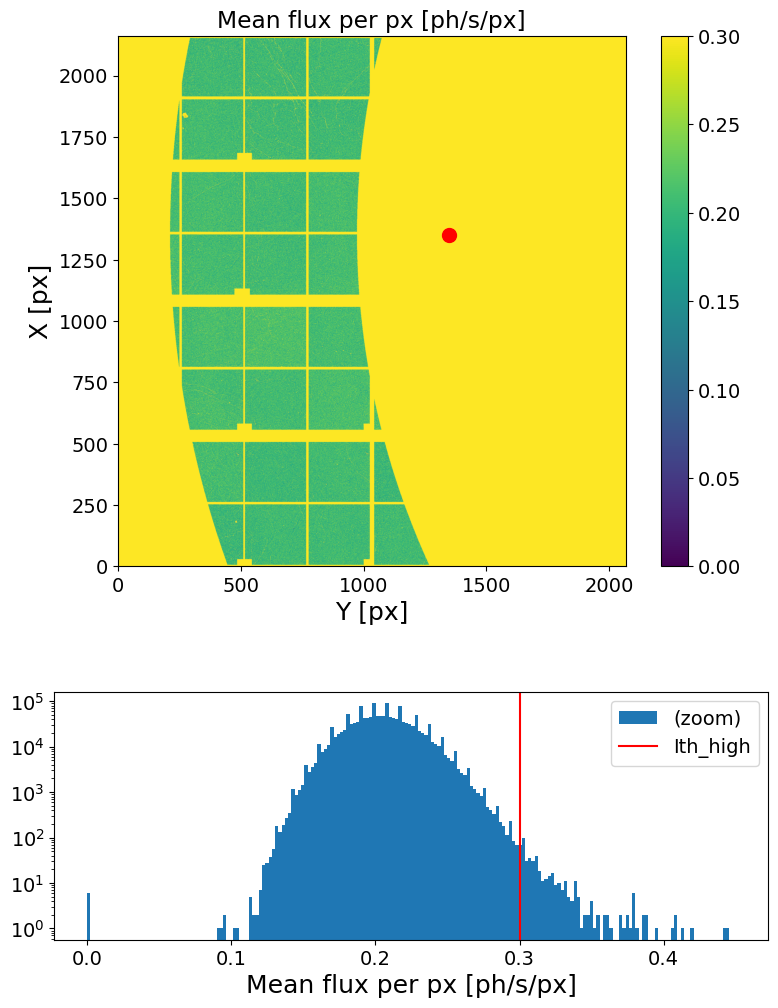

In [10]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [11]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

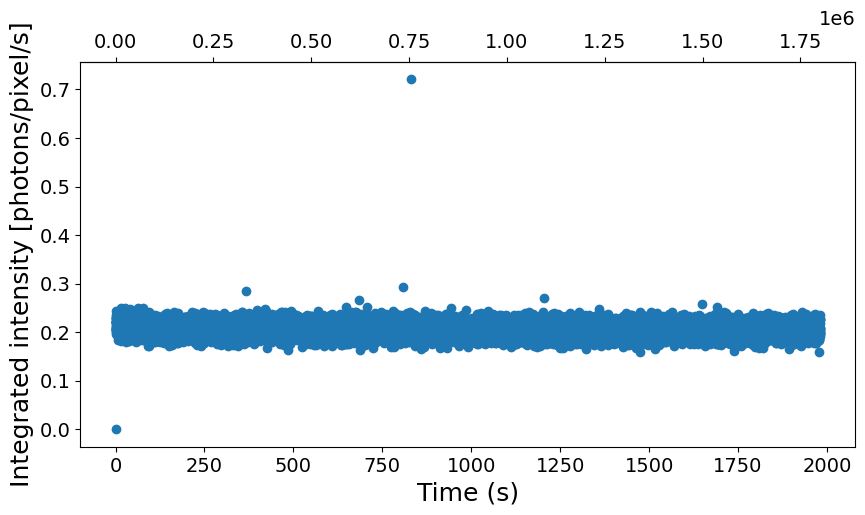

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [13]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 1800288    =>    log2(Nf) = 20.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**20                 20             41.8         751712
1    3*2**19                 19             13.0         227424
2   13*2**17                 17              5.0          96352
3   27*2**16                 16              2.0          30816
4  109*2**14                 14              1.0          14432
5  219*2**13                 13              0.0           6240
6  439*2**12                 12              0.0           2144
7  879*2**11                 11              0.0             96
----------------------------------------------------


In [14]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**19
sparse_depth = 11
dense_depth = 19
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 6.97 s)
	 | 1572864 frames X 1427140 pixels
	 | sparsity = 2.27e-04
	 | memory usage (sparse.csr_array @ float32) = 5.714 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [02:55<00:00,  4.37it/s]


Done! (elapsed time = 175.93 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

Done! (elapsed time = 5.21 s)


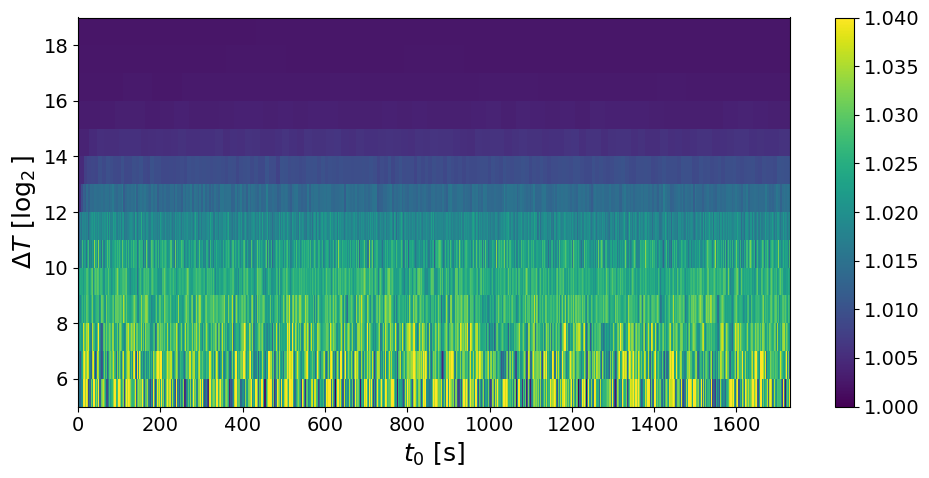

In [15]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [16]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

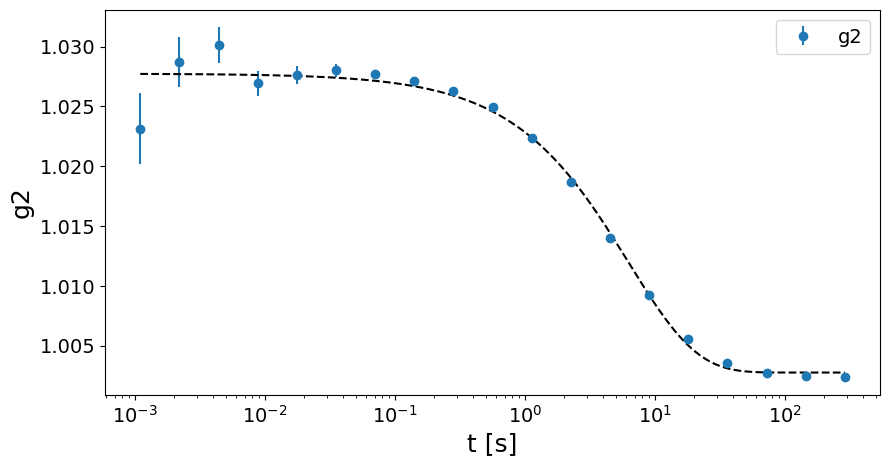

####### Fit parameters #######
tau = 6.2739 +/- 0.8796 s
beta = 0.8294 +/- 0.1123
c = 0.025 +/- 0.001
y0 = 1.0028 +/- 0.0007


In [17]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 240C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [19]:
#######################################
sample_name = 'GeO2_7_240C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00046.h5 (47/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00020.h5 (21/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00016.h5 (17/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00025.h5 (26/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00024.h5 (25/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00026.h5 (27/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00033.h5 (34/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00035.h5 (36/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/36

### Flux check

################################################################################
Maximum count in the hull run -> 4.0
# of pixels above Ith_high treshold ->  3044116 pixels (of 4471016 => 68.09 %)
################################################################################



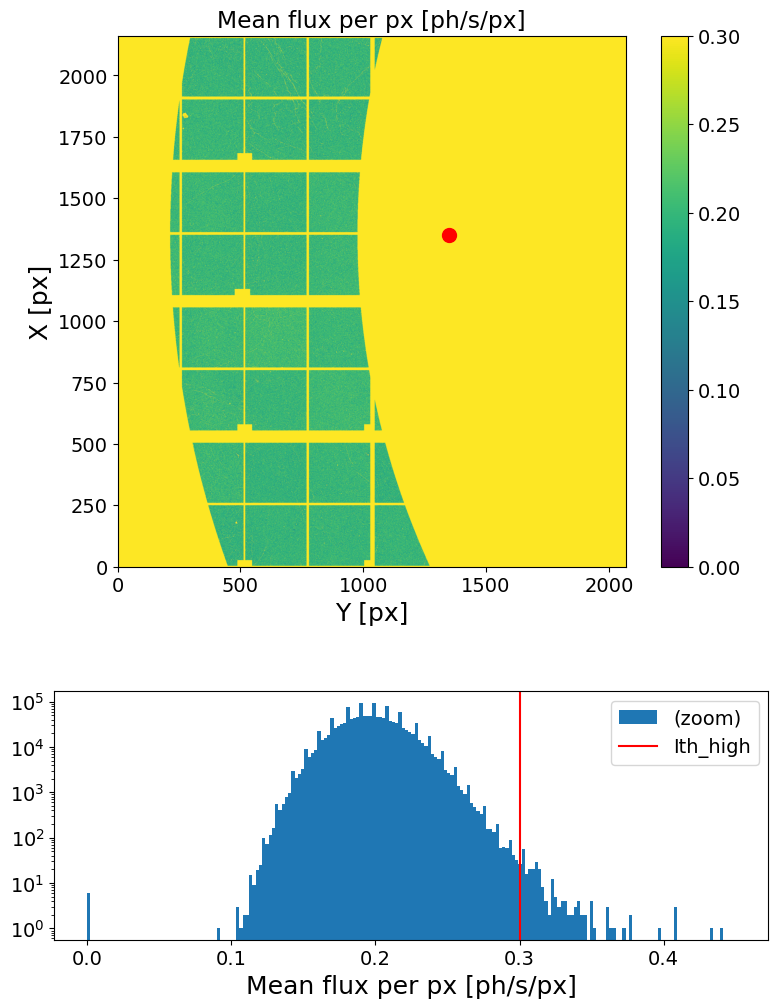

In [20]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [21]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

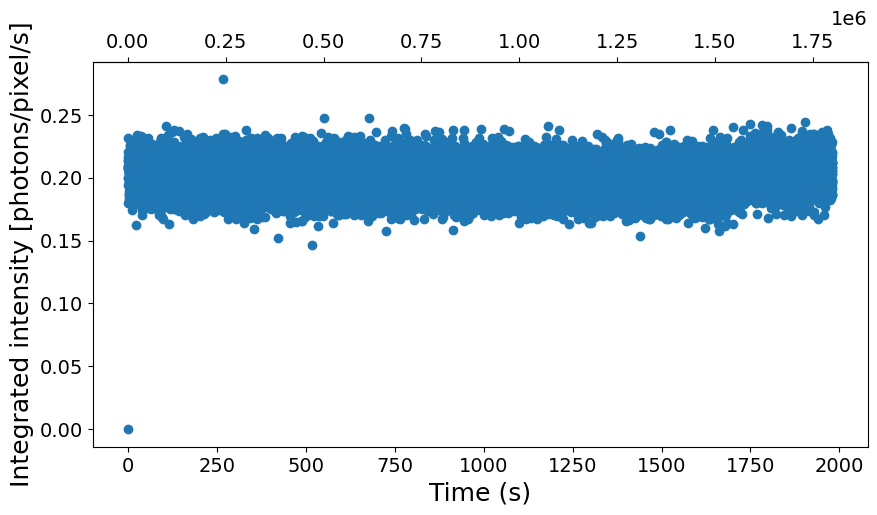

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [23]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 1800288    =>    log2(Nf) = 20.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**20                 20             41.8         751712
1    3*2**19                 19             13.0         227424
2   13*2**17                 17              5.0          96352
3   27*2**16                 16              2.0          30816
4  109*2**14                 14              1.0          14432
5  219*2**13                 13              0.0           6240
6  439*2**12                 12              0.0           2144
7  879*2**11                 11              0.0             96
----------------------------------------------------


In [24]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**19
sparse_depth = 11
dense_depth = 19
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 3.82 s)
	 | 1572864 frames X 1427140 pixels
	 | sparsity = 2.19e-04
	 | memory usage (sparse.csr_array @ float32) = 5.499 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [01:04<00:00, 11.90it/s]


Done! (elapsed time = 64.6 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

Done! (elapsed time = 5.14 s)


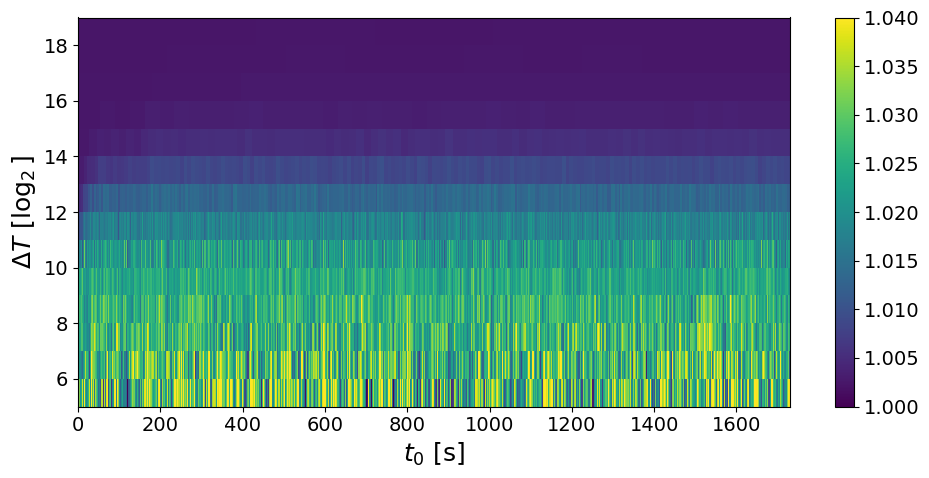

In [25]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [26]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

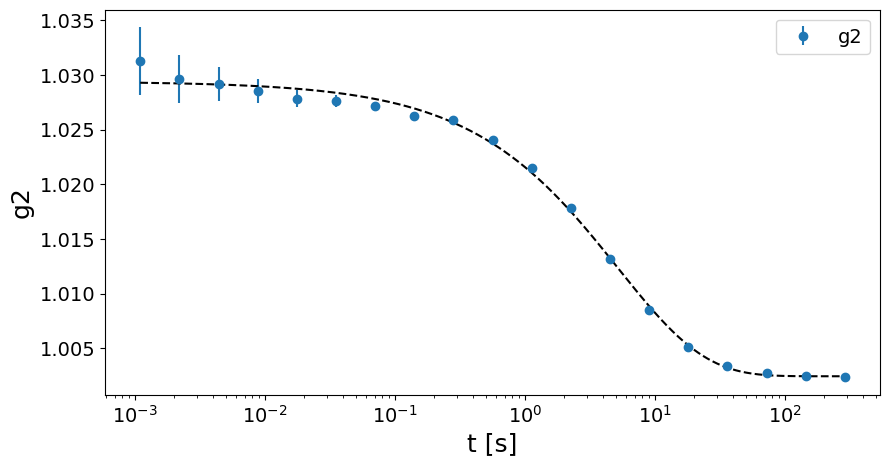

####### Fit parameters #######
tau = 5.1774 +/- 0.395 s
beta = 0.6511 +/- 0.0392
c = 0.027 +/- 0.0005
y0 = 1.0024 +/- 0.0004


In [27]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 310C Q =  0.19 Å, 30 min @ 1ms (1_800_000fm)) (GeO2_7, dataset 1, scan 3)

In [29]:
#######################################
sample_name = 'GeO2_7_310C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00042.h5 (43/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00016.h5 (17/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00018.h5 (19/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00020.h5 (21/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00023.h5 (24/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00030.h5 (31/361 

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3044074 pixels (of 4471016 => 68.08 %)
################################################################################



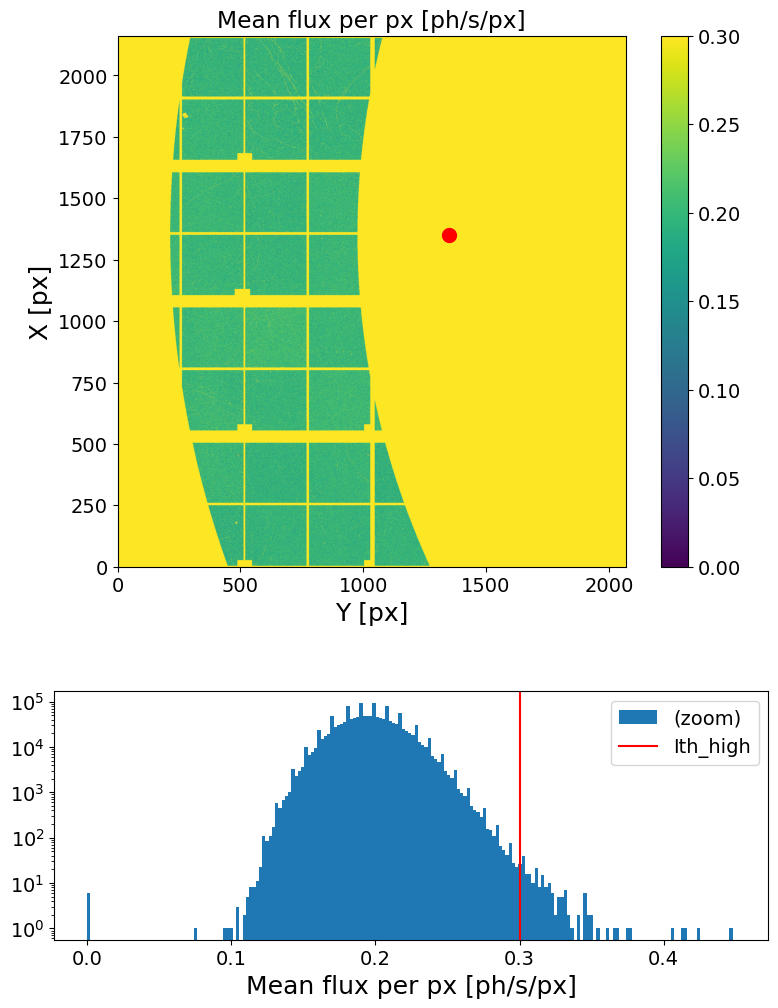

In [30]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [31]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

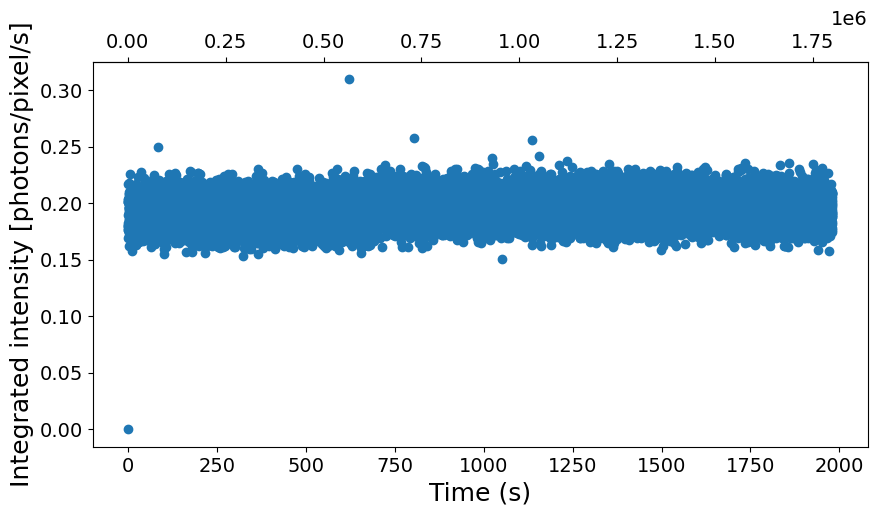

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [33]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 1800288    =>    log2(Nf) = 20.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**20                 20             41.8         751712
1    3*2**19                 19             13.0         227424
2   13*2**17                 17              5.0          96352
3   27*2**16                 16              2.0          30816
4  109*2**14                 14              1.0          14432
5  219*2**13                 13              0.0           6240
6  439*2**12                 12              0.0           2144
7  879*2**11                 11              0.0             96
----------------------------------------------------


In [34]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**19
sparse_depth = 11
dense_depth = 19
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 5.08 s)
	 | 1572864 frames X 1427140 pixels
	 | sparsity = 2.14e-04
	 | memory usage (sparse.csr_array @ float32) = 5.378 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [00:51<00:00, 14.80it/s]


Done! (elapsed time = 51.99 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]

Done! (elapsed time = 5.71 s)


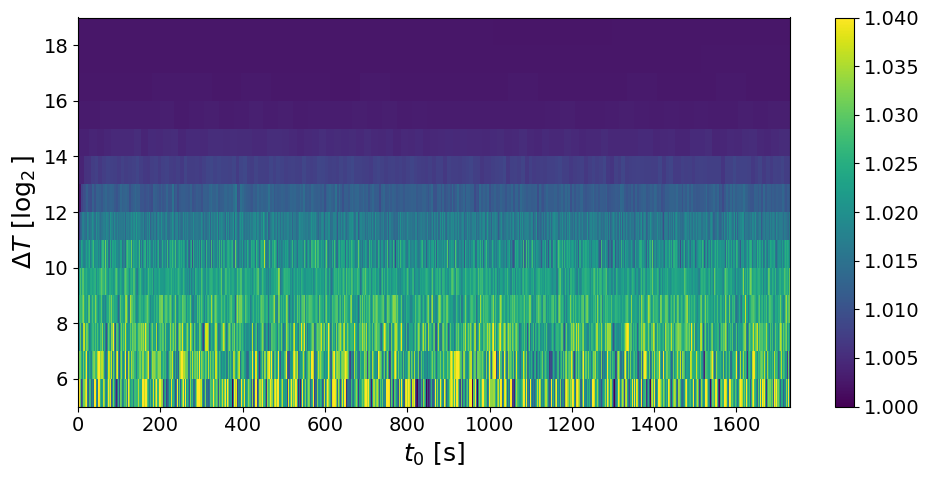

In [35]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [36]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

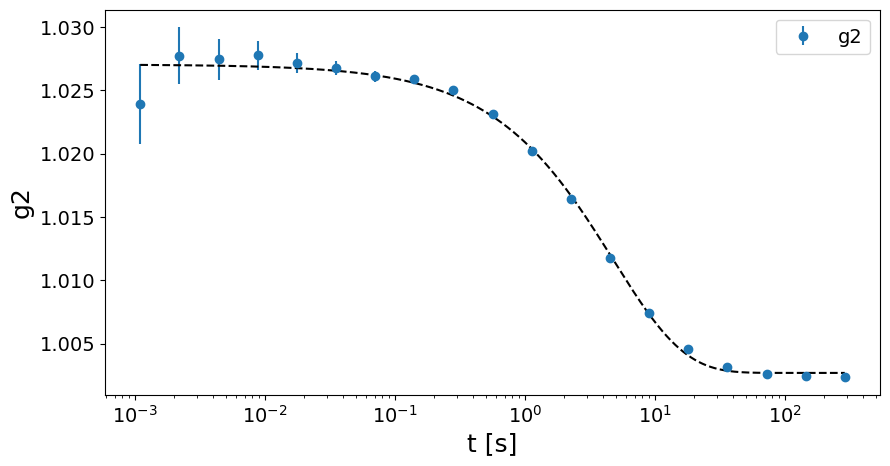

####### Fit parameters #######
tau = 4.7584 +/- 0.4451 s
beta = 0.7928 +/- 0.07
c = 0.0243 +/- 0.0006
y0 = 1.0027 +/- 0.0005


In [37]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 345C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [8]:
#######################################
sample_name = 'GeO2_7_345C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00030.h5 (31/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00036.h5 (37/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00039.h5 (40/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00014.h5 (15/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/720 l

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3044005 pixels (of 4471016 => 68.08 %)
################################################################################



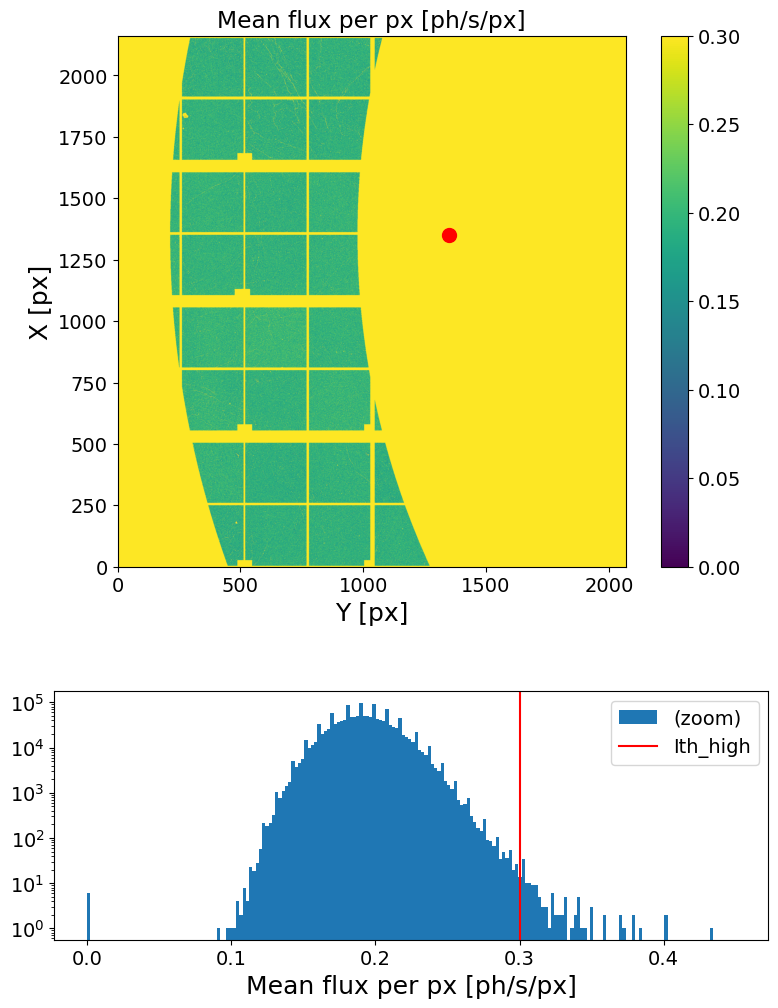

In [9]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [10]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

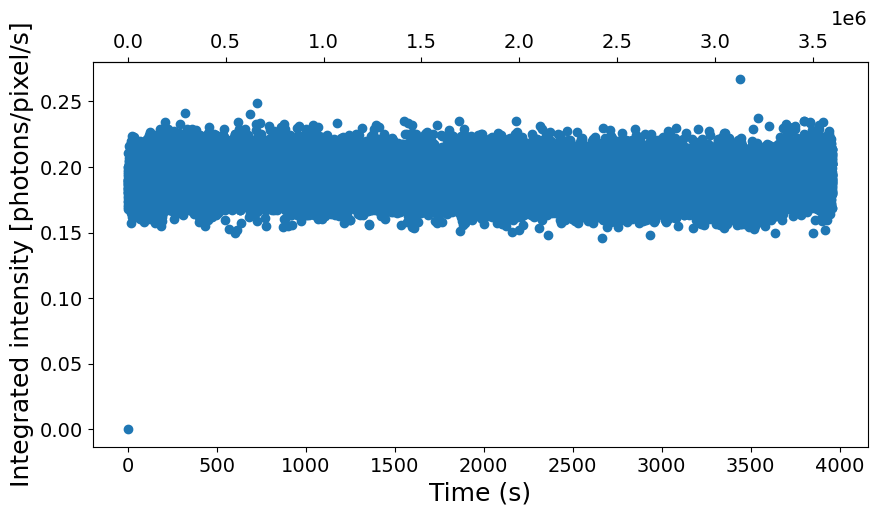

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [12]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 3599664    =>    log2(Nf) = 21.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**21                 21             41.7        1502512
1    3*2**20                 20             13.0         453936
2   13*2**18                 18              5.0         191792
3   27*2**17                 17              2.0          60720
4  109*2**15                 15              1.0          27952
5  219*2**14                 14              0.0          11568
6  439*2**13                 13              0.0           3376
----------------------------------------------------


In [13]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**20
sparse_depth = 12
dense_depth = 20
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 10.22 s)
	 | 3145728 frames X 1427140 pixels
	 | sparsity = 2.11e-04
	 | memory usage (sparse.csr_array @ float32) = 10.585 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [03:24<00:00,  3.75it/s]


Done! (elapsed time = 206.8 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

Done! (elapsed time = 6.65 s)


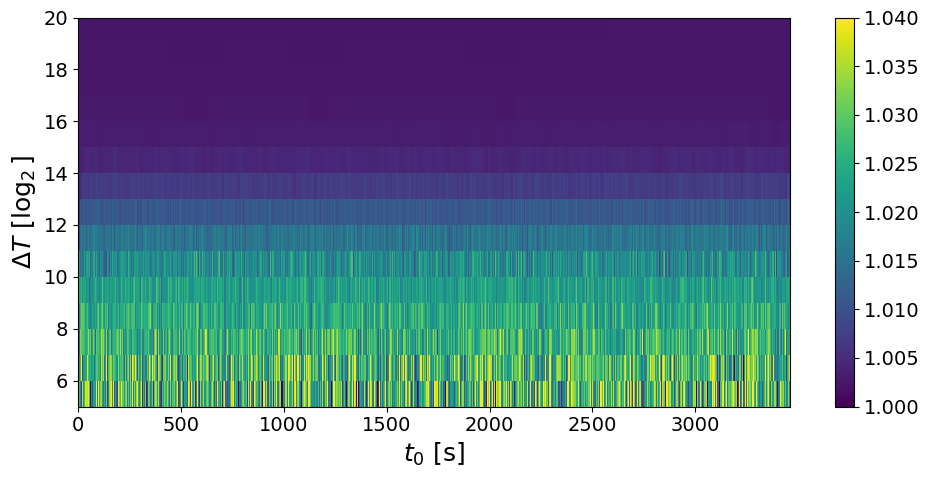

In [14]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [15]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

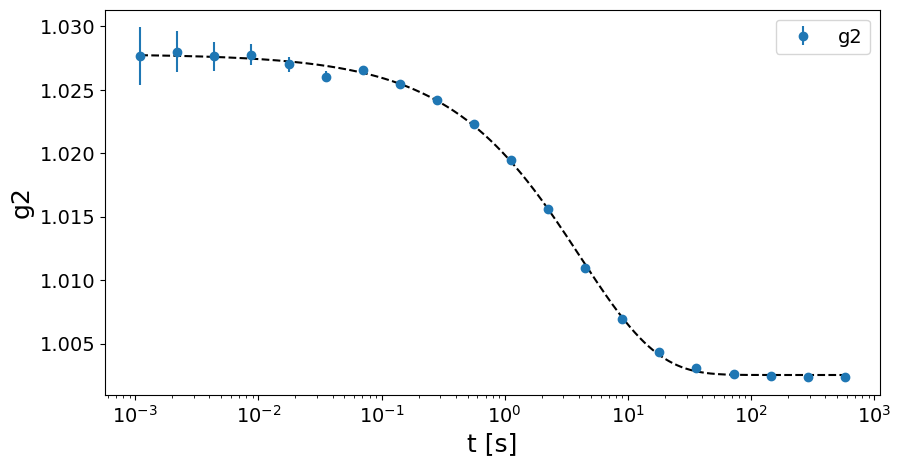

####### Fit parameters #######
tau = 4.1109 +/- 0.1278 s
beta = 0.6912 +/- 0.0187
c = 0.0253 +/- 0.0002
y0 = 1.0025 +/- 0.0001


In [16]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 380C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [17]:
#######################################
sample_name = 'GeO2_7_380C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/720 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3043946 pixels (of 4471016 => 68.08 %)
################################################################################



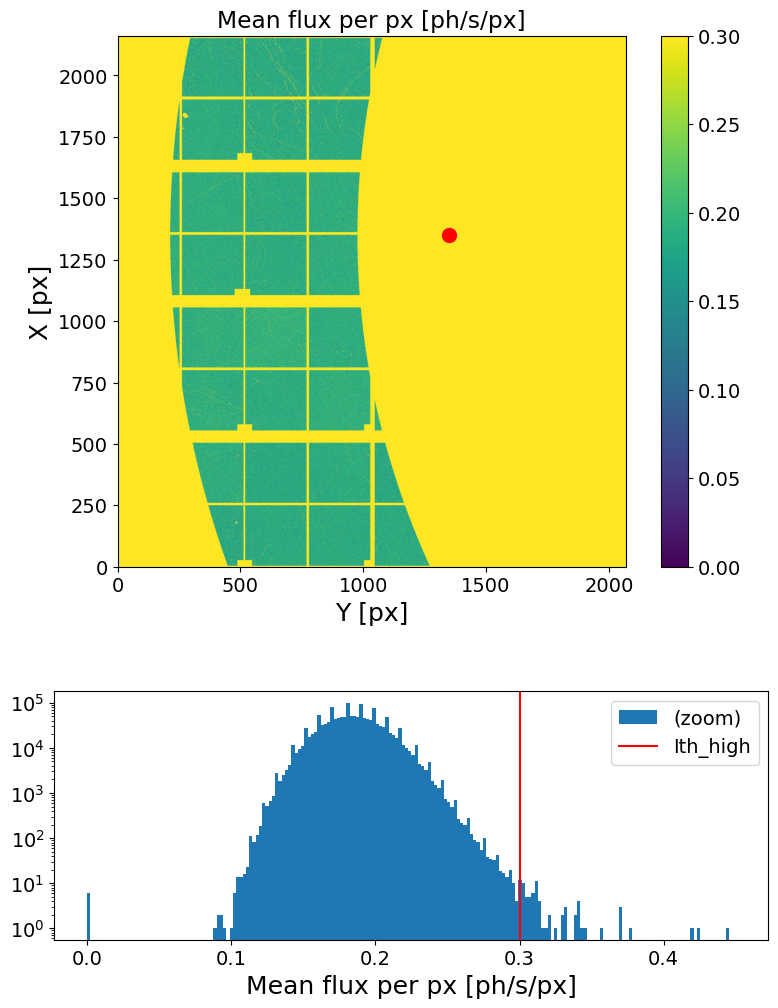

In [18]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [21]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

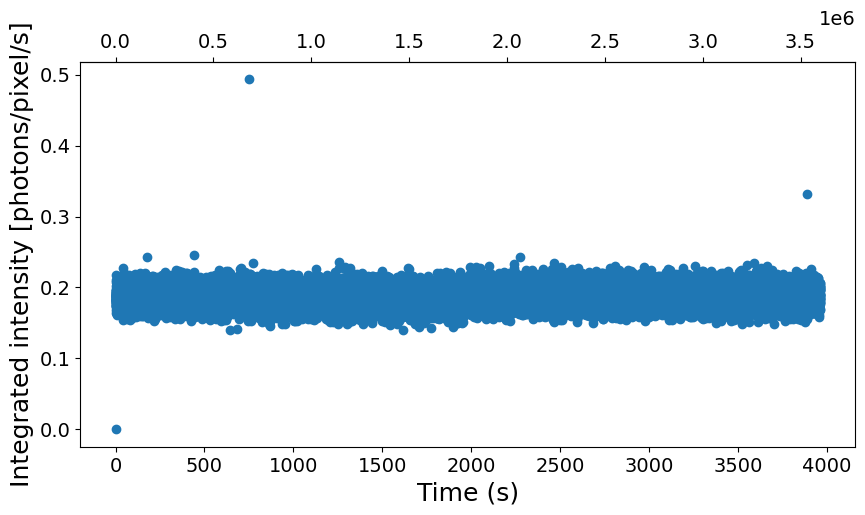

In [22]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [23]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 3599664    =>    log2(Nf) = 21.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**21                 21             41.7        1502512
1    3*2**20                 20             13.0         453936
2   13*2**18                 18              5.0         191792
3   27*2**17                 17              2.0          60720
4  109*2**15                 15              1.0          27952
5  219*2**14                 14              0.0          11568
6  439*2**13                 13              0.0           3376
----------------------------------------------------


In [24]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**20
sparse_depth = 12
dense_depth = 20
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 11.18 s)
	 | 3145728 frames X 1427140 pixels
	 | sparsity = 2.06e-04
	 | memory usage (sparse.csr_array @ float32) = 10.341 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [02:55<00:00,  4.38it/s]


Done! (elapsed time = 176.88 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

Done! (elapsed time = 5.87 s)


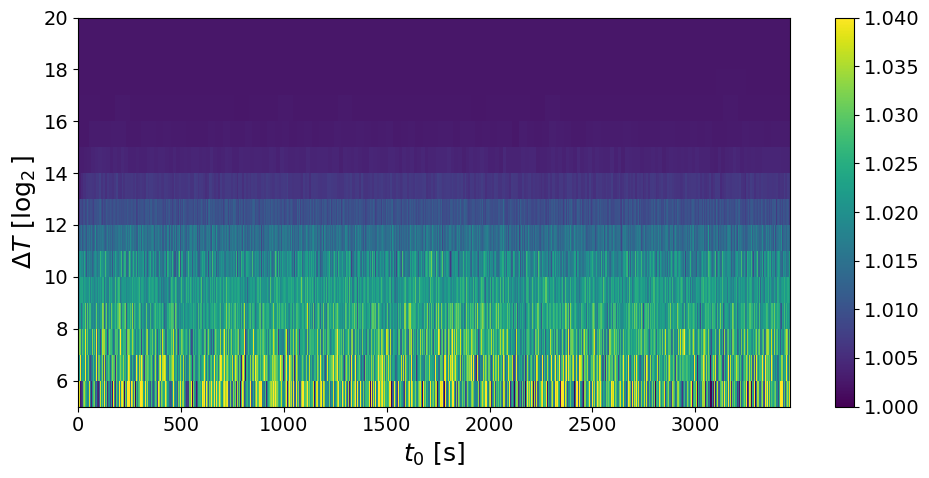

In [25]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [26]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

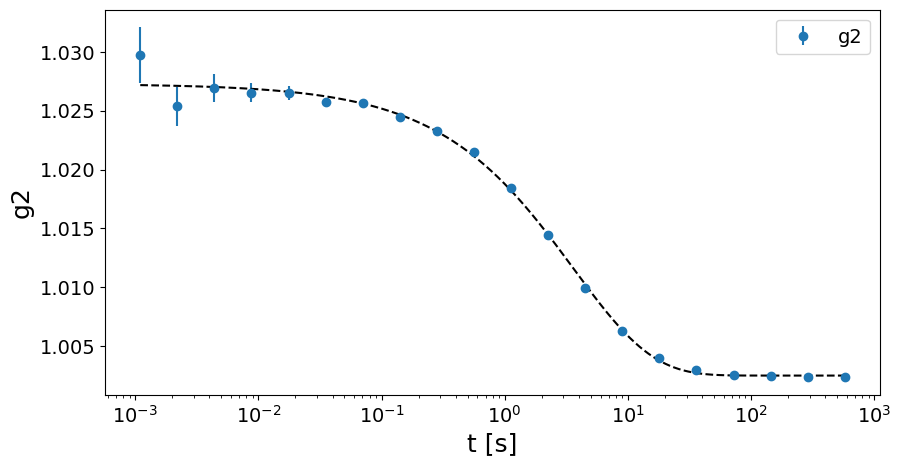

####### Fit parameters #######
tau = 3.603 +/- 0.3195 s
beta = 0.6766 +/- 0.0517
c = 0.0248 +/- 0.0006
y0 = 1.0025 +/- 0.0004


In [27]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 415C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [8]:
#######################################
sample_name = 'GeO2_7_415C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00014.h5 (15/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00019.h5 (20/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00027.h5 (28/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/720 lo

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3043942 pixels (of 4471016 => 68.08 %)
################################################################################



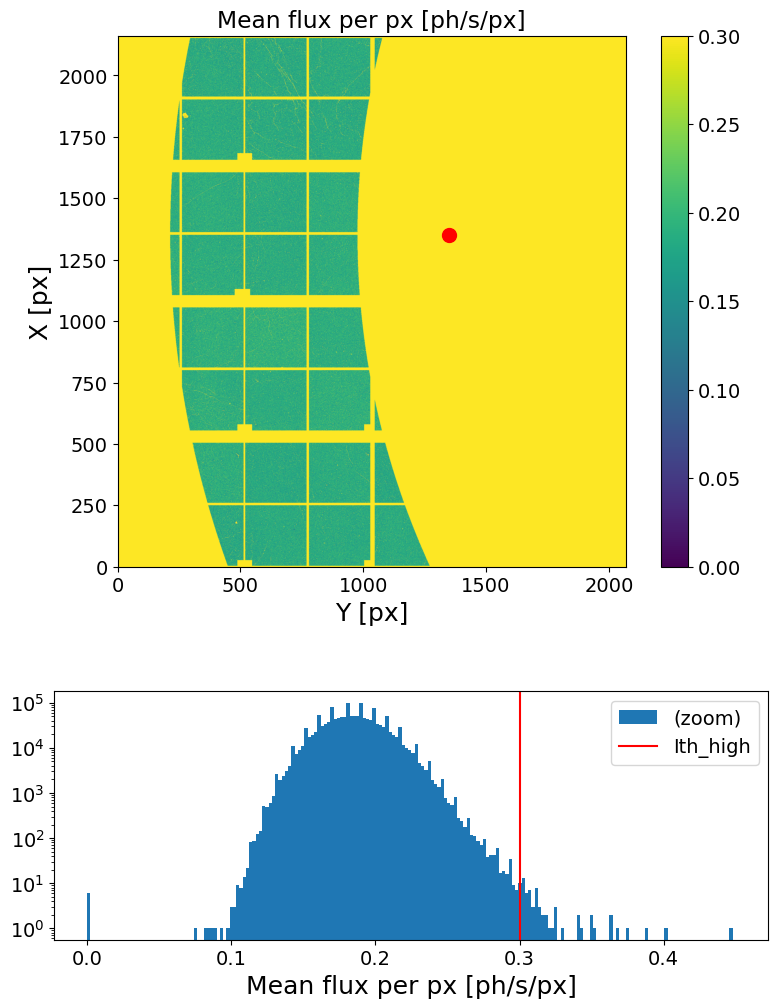

In [9]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [10]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

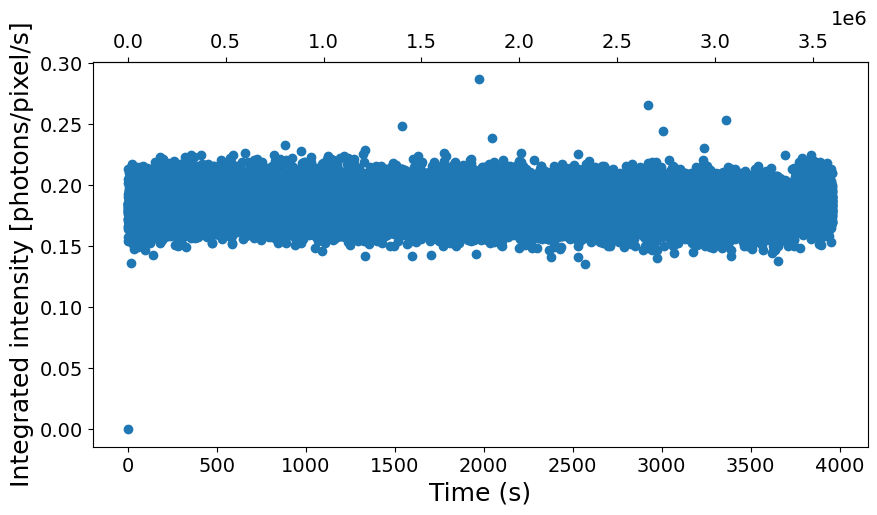

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [12]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 3599664    =>    log2(Nf) = 21.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**21                 21             41.7        1502512
1    3*2**20                 20             13.0         453936
2   13*2**18                 18              5.0         191792
3   27*2**17                 17              2.0          60720
4  109*2**15                 15              1.0          27952
5  219*2**14                 14              0.0          11568
6  439*2**13                 13              0.0           3376
----------------------------------------------------


In [19]:
import importlib
importlib.reload(XPCS)
gc.collect()

2411

In [20]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**20
sparse_depth = 12
dense_depth = 20
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...


Done! (elapsed time = 10.82 s)
	 | 3145728 frames X 1427140 pixels
	 | sparsity = 2.02e-04
	 | memory usage (sparse.csr_array @ float32) = 10.182 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [03:36<00:00,  3.55it/s]


Done! (elapsed time = 216.41 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

Done! (elapsed time = 7.37 s)


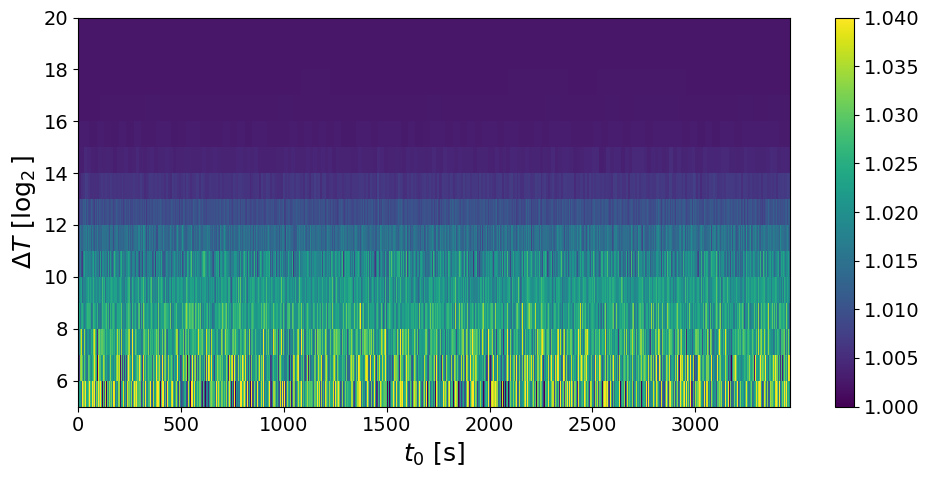

In [21]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [22]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

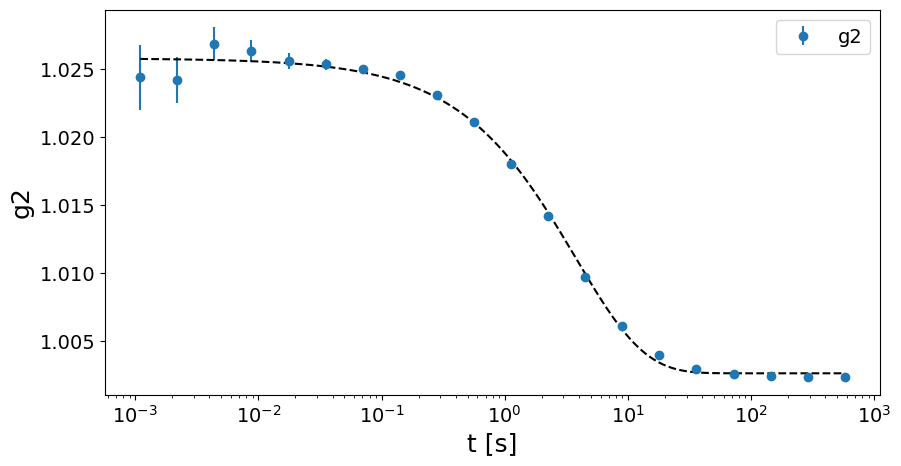

####### Fit parameters #######
tau = 3.753 +/- 0.2683 s
beta = 0.7782 +/- 0.0537
c = 0.0231 +/- 0.0004
y0 = 1.0027 +/- 0.0003


In [23]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 450C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [8]:
#######################################
sample_name = 'GeO2_7_450C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00027.h5 (28/720 loops)
	 -> loading file	 -> loading file  eiger4m_v2_sparse_frame_0_00035.h5eiger4m_v2_sparse_frame_0_00038.h5  (36/720 loops)(39/720 loops)

	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/720 l

### Flux check

################################################################################
Maximum count in the hull run -> 5.0
# of pixels above Ith_high treshold ->  3043914 pixels (of 4471016 => 68.08 %)
################################################################################



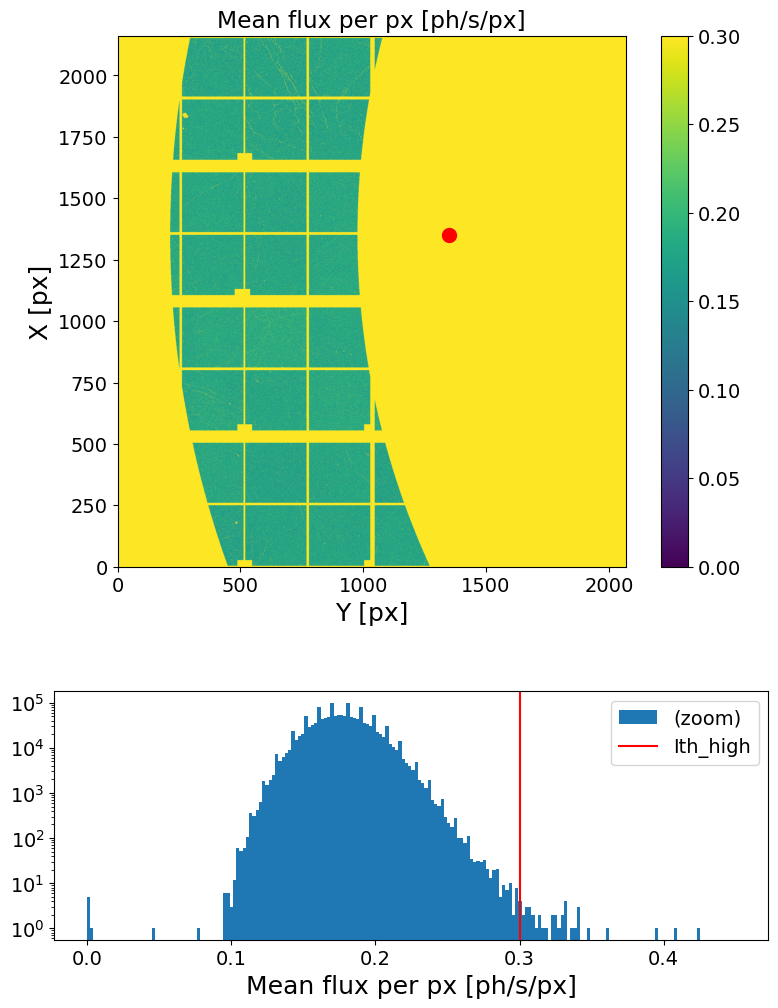

In [9]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=.3, Nfi=int(1e6), Nff=int(1.5e6), load_mask=load_mask)

### Intensity analysis

In [10]:
####################
Lbin = 1
Nstep = 100
mask = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idt_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

<SecondaryAxis: >

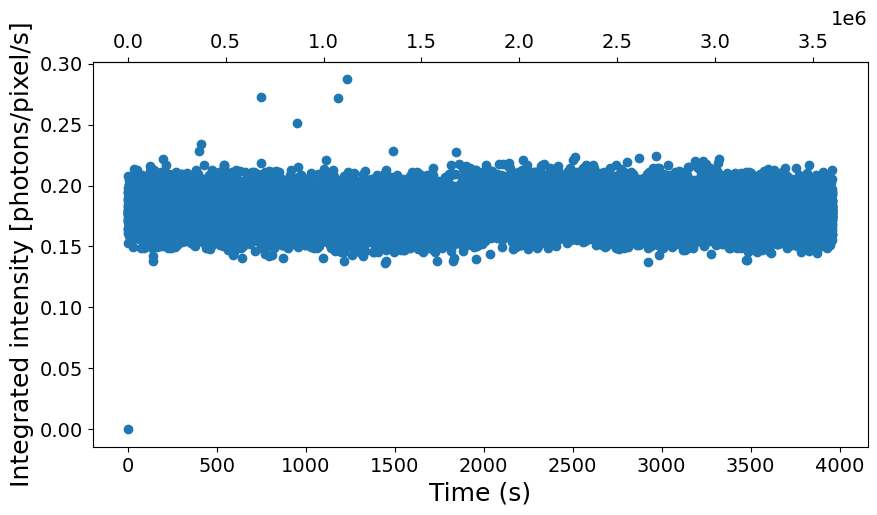

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))

### Correlation

In [12]:
XPCS.print_Nf_choices(e4m_data.shape[0])

       Nf = 3599664    =>    log2(Nf) = 21.78
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**21                 21             41.7        1502512
1    3*2**20                 20             13.0         453936
2   13*2**18                 18              5.0         191792
3   27*2**17                 17              2.0          60720
4  109*2**15                 15              1.0          27952
5  219*2**14                 14              0.0          11568
6  439*2**13                 13              0.0           3376
----------------------------------------------------


In [16]:
#reload environment
import importlib
importlib.reload(XPCS)


<module 'XPCS_tools' from '/mnt/data/DataLSF/2025/ESRF/ID10/HC6209/SCRIPTS/XPCS_library/XPCS_tools.py'>

In [17]:
##### INPUTS #####
Nfi = 1
Nff = 1 + 3*2**20
sparse_depth = 12
dense_depth = 20
mask = None
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)


Loading frames ...
Done! (elapsed time = 10.78 s)
	 | 3145728 frames X 1427140 pixels
	 | sparsity = 1.97e-04
	 | memory usage (sparse.csr_array @ float32) = 9.92 GB
Computing sparse multitau G2t...


100%|██████████| 768/768 [01:31<00:00,  8.39it/s]


Done! (elapsed time = 91.57 s)
Computing dense multitau G2t...


100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

Done! (elapsed time = 4.25 s)


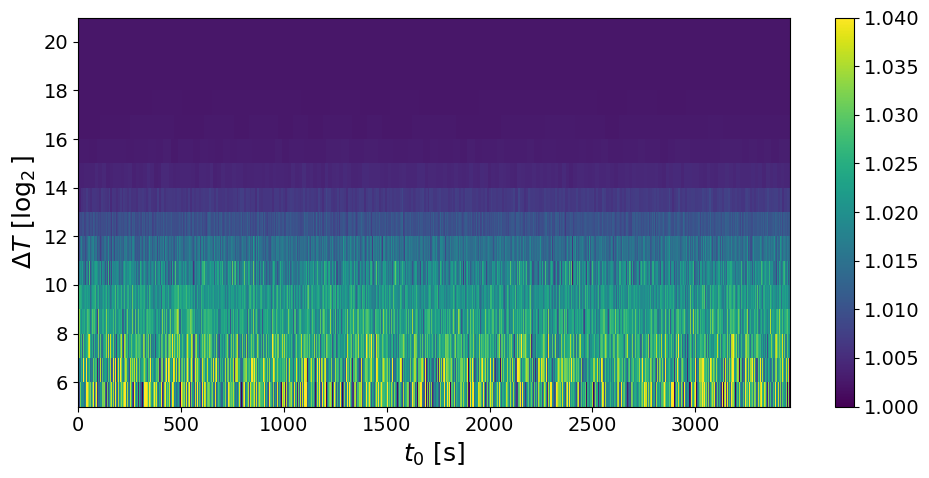

In [18]:
############################
vmin, vmax = 1.0, 1.04
lower_mt = 5
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

In [19]:
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_mt=t_mt, g2_mt=g2_mt, dg2_mt=dg2_mt)

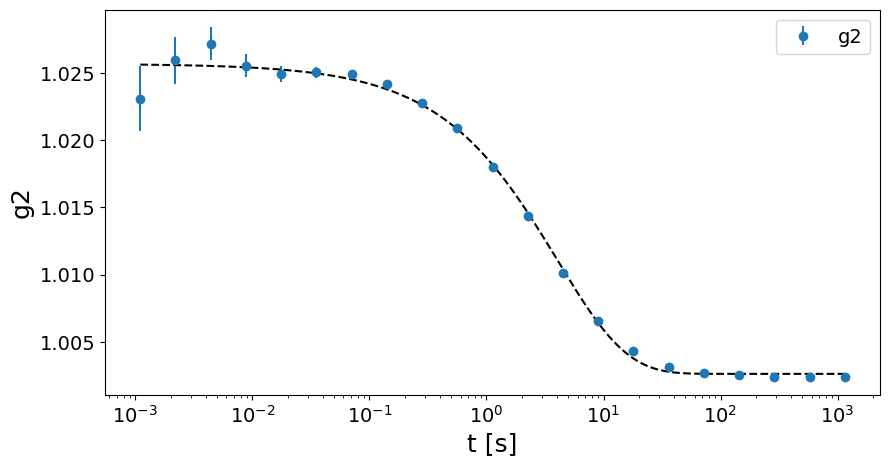

####### Fit parameters #######
tau = 4.0219 +/- 0.3432 s
beta = 0.733 +/- 0.0581
c = 0.023 +/- 0.0005
y0 = 1.0026 +/- 0.0003


In [20]:
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'

plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')

popt, pcov = curve_fit(decorrelation_f, t_mt, g2_mt, sigma=None, p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])) # TO BOUND THE FIT: t1_fit, t2_fit = 0, 1e10,  t[k] ->  t[k][(t1_fit<t[k])*(t[k]<t2_fit)]; g2[k] ->  g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
fit_out.loc[G2tmt[0].size*itime/2] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
fit_out.to_csv(fit_out_folder+'fit_out_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'.csv')

X = np.arange(np.min(t_mt), np.max(t_mt), 1e-4)
Y = decorrelation_f(X, *popt)
plt.plot(X, Y, c='black', ls='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

print('####### Fit parameters #######')
print(f'tau = { round(popt[0],4)} +/- {round(np.sqrt(pcov[0,0]),4)} s')
print(f'beta = {round(popt[1],4)} +/- {round(np.sqrt(pcov[1,1]),4)}')
print(f'c = {   round(popt[2],4)} +/- {round(np.sqrt(pcov[2,2]),4)}')
print(f'y0 = {  round(popt[3],4)} +/- {round(np.sqrt(pcov[3,3]),4)}')

## XPCS scan (T = 485C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 3) fresh point

In [ ]:
#######################################
sample_name = 'GeO2_7_485C'
Ndataset = 1
Nscan = 3
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/720 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/720 loop

## XPCS scan (T = 520C_2 Q =  0.19 Å, 60 min @ 1ms (7_200_000fm)) (GeO2_7, dataset 1, scan 5) fresh point

In [ ]:
#######################################
sample_name = 'GeO2_7_520C'
Ndataset = 1
Nscan = 5
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 7200240
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/201 loop

## XPCS scan (T = 555C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan4) fresh point

In [ ]:
#######################################
sample_name = 'GeO2_7_555C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 7200240
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/601 loop

## XPCS scan (T = 590C Q =  0.19 Å, 120 min @ 1ms (7_200_000fm)) (GeO2_7, dataset 1, scan4) fresh point

In [ ]:
#######################################
sample_name = 'GeO2_7_590C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 7200240
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/601 loop

## XPCS scan (T = 625C Q =  0.19 Å, 180 min @ 1ms (10_800_000fm)) (GeO2_7, dataset 1, scan4)

In [ ]:
#######################################
sample_name = 'GeO2_7_625C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 10799904
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/721 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/721 loo

## XPCS scan (T = 660C Q =  0.19 Å, 180 min @ 1ms (10_800_000fm)) (GeO2_7, dataset 1, scan4)

In [ ]:
#######################################
sample_name = 'GeO2_7_660C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

KeyError: "Unable to synchronously open object (object '4.1' doesn't exist)"

## XPCS scan (T = 660C Q =  0.19 Å, 180 min @ 1ms (10_800_000fm)) (GeO2_7, dataset 1, scan7)

In [ ]:
#######################################
sample_name = 'GeO2_7_660C'
Ndataset = 1
Nscan = 7
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 10799904
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/601 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/601 loo

## XPCS scan (T = 660C Q =  0.19 Å, 180 min @ 1ms (10_800_000fm)) (GeO2_7, dataset 1, scan9)

In [ ]:
#######################################
sample_name = 'GeO2_7_660C'
Ndataset = 1
Nscan = 9
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/361 loop

## XPCS scan (T = 660C Q =  0.19 Å, 240 min @ 1ms (14_400_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_660C'
Ndataset = 1
Nscan = 12
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1800288
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/361 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/361 loop

## XPCS scan (T = 695C Q =  0.19 Å, 240 min @ 1ms (14_400_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_695C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 14399568
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_02200.h5 (2201/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02201.h5 (2202/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02202.h5 (2203/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02203.h5 (2204/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02204.h5 (2205/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02205.h5 (2206/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02206.h5 (2207/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02207.h5 (2208/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02208.h5 (2209/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02209.h5 (2210/380 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_02210.h5 (2211/380 loops)
	 -> loading file eiger4m_v2_spar

KeyboardInterrupt: 

## XPCS scan (T = 730C Q =  0.19 Å, 240 min @ 1ms (14_400_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_730C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 14399568
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/293 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/293 loo

## XPCS scan (T = 660C Q =  0.19 Å, 60 min @ 1ms (3_600_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_660C'
Ndataset = 2
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00100.h5 (101/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00101.h5 (102/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00102.h5 (103/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00103.h5 (104/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00104.h5 (105/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00105.h5 (106/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00106.h5 (107/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00107.h5 (108/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00108.h5 (109/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00109.h5 (110/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00110.h5 (111/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_0

## XPCS scan (T = 520C Q =  0.19 Å, 20 min @ 1ms (1_200_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_520C'
Ndataset = 2
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1200192
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/241 loop

## XPCS scan (T = 300C Q =  0.19 Å, 10 min @ 1ms (600_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_300C'
Ndataset = 1
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 600096
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/121 loops

## XPCS scan (T = 30C Q =  0.19 Å, 10 min @ 1ms (600_000fm)) (GeO2_7, dataset 1, scan 4)

In [ ]:
#######################################
sample_name = 'GeO2_7_30C'
Ndataset = 4
Nscan = 4
Nfi, Nff = None, None
load_mask = e4m_mask * e4m_htmask * bs_mask * Qmask
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=50, load_mask=load_mask)
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 600096
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/121 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/121 loops